---
# 01_featureset_basics.ipynb
---

## Introduction: What is a FeatureSet?

In ModularML, the `FeatureSet` class defines the core data structure used throughout the modeling pipeline. 
It wraps raw input data (like NumPy arrays or dictionaries) and organizes them into clearly separated components:
* **Features**: the inputs to the model
* **Targets**: the the desired outputs or labels to predict
* **Tags**: metadata used to identify, filter, and group samples (e.g., cell ID, temperature, cycling condition)

This notebook introduces the creation and manipulation of `FeatureSet` objects using real-world battery diagnostic data. 
We'll demonstrate how to:
* Load raw data
* Build a FeatureSet from a dictionary
* Define features, targets, and tags
* Split the data into training/validation/testing subsets
* Apply feature transforms for normalization or scaling

## Step 1: Loading Example Data

We begin by downloading an example dataset from our battery health estimation paper: “Fine-tuning for rapid capacity estimation of lithium-ion batteries” ([10.1016/j.ensm.2025.104425](https://doi.org/10.1016/j.ensm.2025.104425)).
This dataset contains time-series voltage responses to 100-second DC pulses collected across the life of several lithium-ion cells.
More information on the dataset and usage can be found on the following GitHub repository: [REIL-UConn/fine-tuning-for-rapid-soh-estimation]{https://github.com/REIL-UConn/fine-tuning-for-rapid-soh-estimation.git}.


We'll download and load the data from GitHub. 
The file is a `.pkl` (pickled Python object) containing a dictionary of key-value arrays.

In [1]:
import urllib.request
import warnings
import pickle
from pathlib import Path

DATA_URL = Path("https://raw.githubusercontent.com/REIL-UConn/fine-tuning-for-rapid-soh-estimation/main/processed_data/UConn-ILCC-NMC/data_slowpulse_1.pkl")
DATA_DIR = Path("downloaded_data")
DATA_PATH = DATA_DIR / "data_slowpulse_1.pkl"
DATA_DIR.mkdir(exist_ok=True, parents=True)

if not DATA_PATH.exists():
    print("Downloading data...")
    urllib.request.urlretrieve(DATA_URL, DATA_PATH)
    print("Download complete.")
else:
    print("Data already downloaded.")

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    data = pickle.load(open(DATA_PATH, 'rb'))

print(f"Available keys: {list(data.keys())}")
print(f"Total number of samples: {len(data[list(data.keys())[0]])}")

Data already downloaded.
Available keys: ['cell_id', 'group_id', 'rpt', 'num_cycles', 'soc', 'soc - coulomb', 'pulse_type', 'voltage', 'q_dchg', 'soh', 'dcir_chg_10', 'dcir_dchg_10', 'dcir_chg_20', 'dcir_dchg_20', 'dcir_chg_30', 'dcir_dchg_30', 'dcir_chg_40', 'dcir_dchg_40', 'dcir_chg_50', 'dcir_dchg_50', 'dcir_chg_60', 'dcir_dchg_60', 'dcir_chg_70', 'dcir_dchg_70', 'dcir_chg_80', 'dcir_dchg_80', 'dcir_chg_90', 'dcir_dchg_90']
Total number of samples: 24048


## Step 2: Understanding the Data Format

Our data is structured as a dictionary, where each key corresponds to a signal or property:
* `voltage`: the time-series voltage response during a 100-second pulse (shape: [n_samples, 101])
* `soh`: state-of-health, a float between ~0.5 and 1.0
* `cell_id`, `group_id`, `pulse_type`, `soc`: metadata about the sample

We'll now map these to the correct FeatureSet roles:
* **Feature**: `voltage`
* **Target**: `soh`
* **Tags**: `cell_id`, `group_id`, `pulse_type`, `pulse_soc`


## Step 3: Creating a FeatureSet

To create a `FeatureSet`, we use the `from_dict()` constructor. 
We must assign a `label`, which uniquely identifies this `FeatureSet` within the broader modeling pipeline (e.g., when connecting to model stages).

In [2]:
import modularml as mml
from modularml.core import FeatureSet

fs = FeatureSet.from_dict(
    label='PulseFeatures',
    data={
        'voltage': data['voltage'],
        'soh': data['soh'],
        'cell_id': data['cell_id'],
        'group_id': data['group_id'],
        'pulse_type': data['pulse_type'],
        'pulse_soc': data['soc'],
    },
    feature_keys='voltage',
    target_keys='soh',
    tag_keys=['cell_id', 'group_id', 'pulse_type', 'pulse_soc']
)
fs

FeatureSet(label='PulseFeatures', n_samples=24048)

## Step 4: Exploring Tags and Filtering

Tags let us group, filter, and analyze our dataset

In [3]:
print("Unique cell IDs:", fs.get_all_tags(format=mml.DataFormat.PANDAS)['cell_id'].unique())
print("Pulse types:", fs.get_all_tags(format=mml.DataFormat.PANDAS)['pulse_type'].unique())

Unique cell IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Pulse types: ['chg' 'dchg']


We can easily filter to only samples matching specific tag values.

The `.filter` method takes keyword arguments, where keys can correspond to any attribute of the samples' tags, features, or targets.

In [4]:
charge_samples = fs.filter(pulse_type='chg')
print(charge_samples)
print(f"Filtered to {len(charge_samples.samples)} charge-only samples.")

FeatureSet(label='filtered', n_samples=12024)
Filtered to 12024 charge-only samples.


Note that the `.filter` method returns a new `FeatureSet` containing copies of the filtered samples.

By default, it is returned with a label of `'filtered'`, but we can set a new label with `.set_label`.


In [5]:
charge_samples.set_label("ChargePulseFeatures")
print(charge_samples)

FeatureSet(label='ChargePulseFeatures', n_samples=12024)


## Step 5: Splitting Into Train/Val/Test

To train a machine learning model properly, we must divide our data into non-overlapping subsets. 

ModularML provides several built-in splitting methods:
* `FeatureSet.split_random()`: creates subsets by assigning random proportions of all samples to each split
* `FeatureSet.split_by_condition()`: creates subsets using any number of explicit conditions

For example, a random 50% train, 30% valdation, and 20% test split can be achieved with:

In [6]:
charge_samples.split_random(ratios={'train': 0.5, 'val':0.3, 'test':0.2})

[FeatureSubset(label='train', n_samples=6012),
 FeatureSubset(label='val', n_samples=3607),
 FeatureSubset(label='test', n_samples=2405)]

Note that the `.split_...` methods of FeatureSet return the created FeatureSubsets in addition to storing them internally. 

We can validate that these subsets are retained in FeatureSet using the `.available_subsets` property:

In [7]:
charge_samples.available_subsets

['train', 'val', 'test']

Normally, when splitting data, you need to be more specific with the segmentation.

In our case, we need to ensure each split contains at a minimum, unique cell IDs (`'cell_id'`).
Having pulse responses from the same cell in both the training and test sets would lead to data leakage and introduce bias into the model’s performance.

To further strengthen our evaluation, we can split by cycling conditions (`'group_id'`), ensuring that the test set includes only battery cycling scenarios that the model thas never encountered during training.
This approach provides a clearer picture of the model’s ability to generalize to unseen conditions, which is essential for assessing its suitability for real-world deployment.

To achieve this type of segementation, we have a couple options:

1. Utilize the `group_by` argument of `split_random`
	- If we set `group_by='group_id'`, then all samples are first grouped into like cycling groups before randomly selecting for subsets
	- This is essentially saying "take a random selection of `'group_id'` with the defined ratios"

2. Provide explicit grouping conditions with `split_by_condition`
	- This splitting method allows for defining a set of conditions applied to any key within each sample. 
	- For example, we could split into subsets based on the `'group_id'` value:
		``` python
		charge_samples.split_by_condition(train={'group_id': lambda x: x < 5}, val=..., ...)
		```
	- This assigns all cycling groups with IDs < 5 to the `train` set.


For our case, where we only need to account for a single tag (`'group_id'`), we can just use `split_random`.

However, `split_by_condition` becomes very powerful when you need segmentation across multiple tags. 
Say for example you wanted to add another segmentation based on the sample's state of health (`'soh'`).
Then we could do:

``` python
	charge_samples.split_by_condition(
		train={
			'group_id': [1,2,3],
			'soh': lambda x: x >= 90.0,
		},
		val=..., 
		...
	)
```
Now the `train` subset contains specific cycling groups and only the early-life data, where state-of-health is above 90%. 
It becomes incredibly easy to format the FeatureSet for advanced model training and evaluations.

Let's get back to our example ...

First we'll have to remove the subsets created previously. 
This is easily achieved with the `clear_subsets` method.

In [8]:
charge_samples.clear_subsets()
charge_samples.available_subsets

[]

Next, we'll create subsets with the same {50% train, 30% validation, and 20% test} split ratio, but now we'll ensure unique cycling conditions in each set using the `group_by` argument.

In [9]:
charge_samples.split_random(
	ratios={'train': 0.5, 'val': 0.3, 'test':0.2},
 	group_by='group_id'
)

[FeatureSubset(label='train', n_samples=5607),
 FeatureSubset(label='test', n_samples=2097),
 FeatureSubset(label='val', n_samples=4320)]

Since there are only 11 unique groups, the resulting ratios won't be perfect, but we can check how close it got.

In [10]:
import numpy as np

for subset_label, subset in charge_samples.subsets.items():
    msg = f"{subset_label}: n={len(subset)} ({len(subset)/len(charge_samples)*100:.01f}% of all samples)\n"
    msg += f"  > Unique group_ids: {np.unique(subset.get_all_tags()['group_id'])}"
    print(msg)

train: n=5607 (46.6% of all samples)
  > Unique group_ids: [ 1  4  7  8 11]
test: n=2097 (17.4% of all samples)
  > Unique group_ids: [ 2  9 10]
val: n=4320 (35.9% of all samples)
  > Unique group_ids: [3 5 6]


Great! We now have `train`, `val`, and `test` subsets, each with a unique set of cycling conditions.

## Step 6: Feature Transforms

To make model training more stable, it's common to normalize input features. 
ModularML provides this functionality with a `FeatureTranform` class that wrap common normalization/scaling methods like those from the `sklearn.preprocessing` module. 
It also defines a few custom ones. 

We can view the list of available transform using the `get_supported_scalers` method.

This provides the tranform name and corresponding class definition.

In [11]:
from modularml.core import FeatureTransform

FeatureTransform.get_supported_scalers()

{'standard': sklearn.preprocessing._data.StandardScaler,
 'minmax': sklearn.preprocessing._data.MinMaxScaler,
 'maxabs': sklearn.preprocessing._data.MaxAbsScaler,
 'robust': sklearn.preprocessing._data.RobustScaler,
 'normalize': sklearn.preprocessing._data.Normalizer,
 'quantile': sklearn.preprocessing._data.QuantileTransformer,
 'power': sklearn.preprocessing._data.PowerTransformer,
 'sample_minmax': modularml.preprocessing.per_sample_min_max.PerSampleMinMaxScaler,
 'sample_zero': modularml.preprocessing.per_sample_zero.PerSampleZeroStart,
 'negate': modularml.preprocessing.negate.Negate,
 'absolute': modularml.preprocessing.absolute.Absolute,
 'segmented': modularml.preprocessing.segmented_scaler.SegmentedScaler}

Before we start applying transforms, let's look at our data. 

Several data accessor methods are provided on FeatureSets including:

* `get_all_features(format:modularML.DataFormat)`: returns all features values from all samples in FeatureSet

* `get_all_targets(format:modularML.DataFormat)`: returns all target values from all samples in FeatureSet

* `get_all_tags(format:modularML.DataFormat)`: returns all tags values from all samples in FeatureSet


The `format` argument allows the data to be returned in any specified format (e.g., Pandas DataFrame, dict of lists, numpy arrays, etc). 
See the documentation for more details on format types. 


Let's make a quick plot of the underlying `voltage` feature in each subset.
We'll wrap it in a function so we can plot it again later.

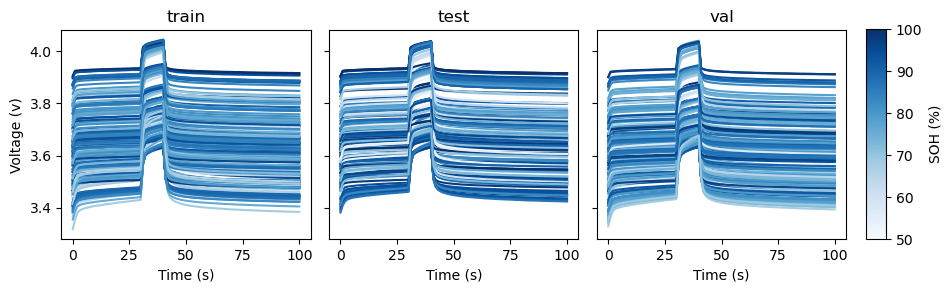

In [12]:
import matplotlib.pyplot as plt

def plot_voltages(fs: FeatureSet, n_samples:int = 200, seed:int=13):
    """
    Plot the 'voltage' feature contained in the FeatureSet. 
    Each subset will get its own panel.
    Colors by SOH (dark blue = high SOH, light blue = low SOH)
    Args:
        fs (FeatureSet): FeatureSet to use.
        n_samples (int, optional): The number of samples in `fs` that will 
              get plotted. Defaults to 200.
        seed (int, optional): A seed to ensure the same samples get plotted
              with repeated calls. Defaults to 13.
    """
    rng = np.random.default_rng(seed)
    scm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=50, vmax=100))

    # Create figure with panels for each subset
    fig, axes = plt.subplots(figsize=(10,3), ncols=fs.n_subsets, sharex=True, sharey=True)
    for i, (subset_label, subset) in enumerate(fs.subsets.items()):
        # For each subset, get all voltage features and group_ids
        voltages = subset.get_all_features(format=mml.DataFormat.DICT_NUMPY)['voltage']
        sohs = subset.get_all_targets(format=mml.DataFormat.DICT_NUMPY)['soh']
    
        # Select n_samples
        sample_idxs = rng.choice(np.arange(0, len(voltages)), size=n_samples)
        for idx in sample_idxs:
            axes[i].plot(voltages[idx], color=scm.to_rgba(sohs[idx]))
  
        axes[i].set_title(subset_label)
        axes[i].set_xlabel('Time (s)')
    axes[0].set_ylabel('Voltage (v)')
    
    # Adjust main subplot area to leave space on the right for colorbar
    fig.tight_layout(pad=1)
    fig.subplots_adjust(right=0.85)

    # Add colorbar as a dedicated panel on the far right
    cbar_ax = fig.add_axes([0.87, 0.19, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scm, cax=cbar_ax)
    cbar.set_label('SOH (%)')
    return fig, axes

fig, axes = plot_voltages(charge_samples, n_samples=200)
plt.show()

Let's apply a MinMaxScaler to ensure all data is in the range [0, 1].

Applying transform to FeatureSet object is performed with the `fit_transform` method.
It requires three arguments:

* `fit`: a string specifying on which segment of the FeatureSet the transform should be fit to
* `apply`: a string specifying to which segment of the FeatureSet the transform should be applied to
* `transform`: a `FeatureTransform` instance defining the transformation


The `fit` and `apply` strings can take the form of `'{subset}.{component}.{key}'` where
* `component` is the only required value and must be either `'features'` or `'targets'`
  	* If `subset` is omitted (e.g., `fit='features'`), then the transform is fit to features from all subsets.
* `key` can be a specific feature or target (e.g., just the `'voltage'` feature)


A `FeatureTransform` can be defined with an instance of a supported scaler/transform (e.g., `sklearn::StandardScaler`) or with the name of the scaler, as provided in `FeatureTransform.get_supported_scalers().keys()`. For example, the following are equivalent:
``` python
from sklearn.preprocessing import StandardScaler
FeatureTransform(StandardScaler())
FeatureTransform('standard')
```

To prevent data leakage, we only want to fit our transform to the `train` subset, but apply it to all subsets.

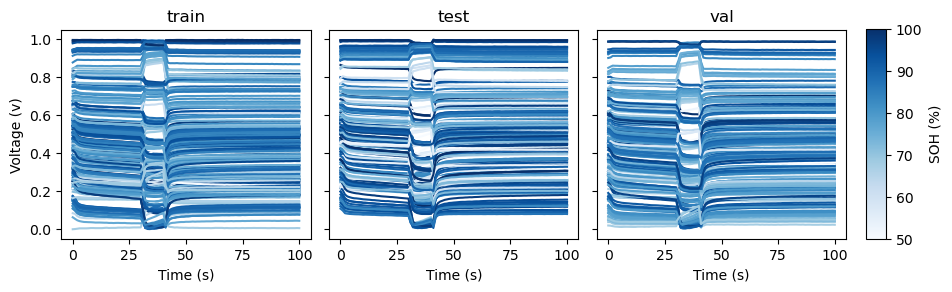

In [13]:
charge_samples.fit_transform(
    fit="train.features",
    apply="features",
    transform=FeatureTransform('minmax')
)
fig, axes = plot_voltages(charge_samples)
plt.show()

Say we don't like that transform and want to apply a different one.
We can remove all transforms on our data by using `undo_all_transforms`. 
> Note that we can optionally provide an `on` argument, which defines whether to undo all transforms (`on=None`, default), all feature transforms (`on='features'`), or all target transforms (`on='targets'`)

In [14]:
charge_samples.undo_all_transforms()

Our feature signals start at random voltage levels, but maybe we know that health information is encoded in the curvature of the pulse response (e.g., the rise/decay rate in the middle portion of the voltage reading).

In this case, we might want to shift all samples so they start at a value of 0. This is achieved with the `'sample_zero'` or `PerSampleZeroStart` transform.

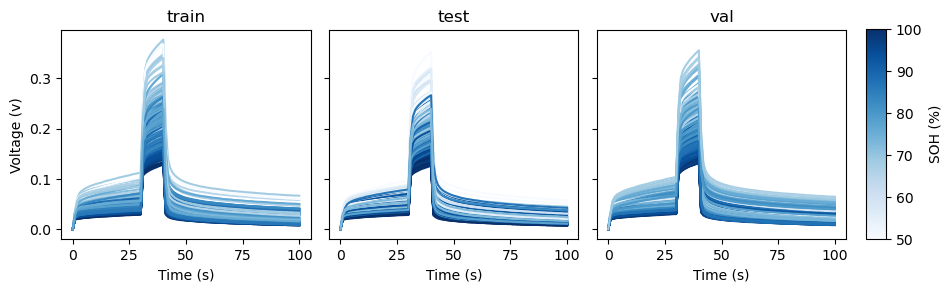

In [15]:
from modularml.preprocessing import PerSampleZeroStart, MinMaxScaler

charge_samples.fit_transform(
    fit="train.features",
    apply="features",
    transform=FeatureTransform(PerSampleZeroStart())
)
fig, axes = plot_voltages(charge_samples)
plt.show()

Now we might want to reapply the MinMax scaler to ensure all values are between 0 and 1.

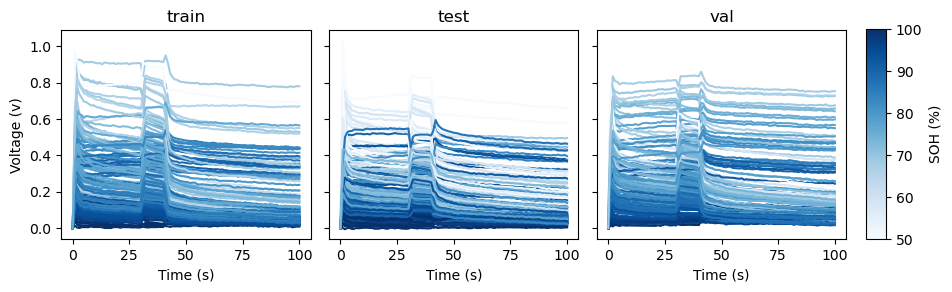

In [16]:
charge_samples.fit_transform(
    fit="train.features",
    apply="features",
    transform=FeatureTransform(MinMaxScaler())
)
fig, axes = plot_voltages(charge_samples)
plt.show()

We can undo a single transform at a time using the `inverse_transform` method.

Here, we remove on the last 'minmax' transform.

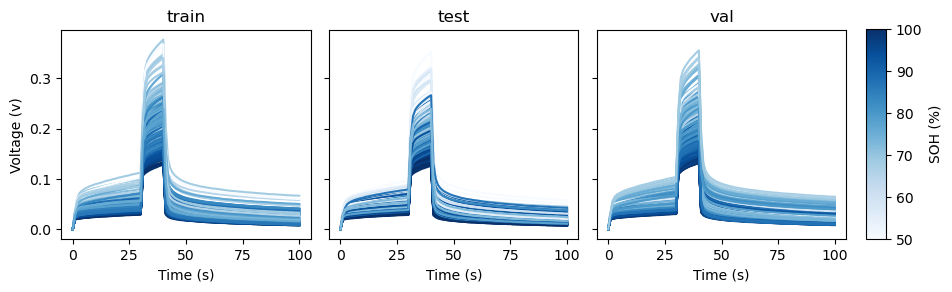

In [17]:
charge_samples.inverse_transform()
fig, axes = plot_voltages(charge_samples)
plt.show()

With the tracked application of transforms, it becomes very easy to experiment with different feature preprocessing techniques. 

We can even create customs transforms. 
Any object can be passed to `FeatureTransform(scaler=...)` so long as it defines a `fit()`, `tranform()`, and `inverse_tranform()` method.

For example, we see that the voltage response can be broken into three distinct segments: (0, 30) seconds, (30,40) seconds, and (40,100) seconds. Maybe we want to create a scaler that create independent scalers for each of those segments.

Let's create `MyScaler` that does just that. On initiallization it takes any scaler, that will be duplicated and fit to each defined segment. If we use the `PerSampleZeroStart` for each segment, we can shift the start of each segment to zero.

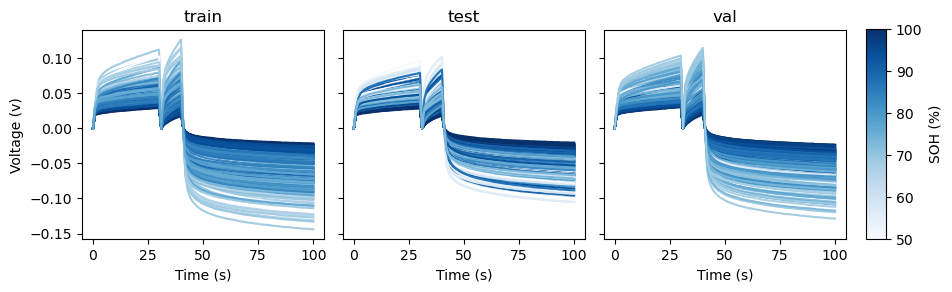

In [18]:
from modularml.preprocessing import PerSampleZeroStart, MinMaxScaler

class MyScaler:
    def __init__(self, scaler=None):
        self.scaler = scaler if scaler is not None else MinMaxScaler()
        self._segment_scalers = []
        self._boundaries = [0, 31, 41, 101]
    
    def fit(self, X: np.ndarray):
        # X has shape: (n_samples, feature_len)
        self._segment_scalers.clear()
        for i in range(len(self._boundaries) - 1):
            start, end = self._boundaries[i], self._boundaries[i + 1]
            segment = X[:, start:end]
            scaler = self.scaler.__class__(**self.scaler.get_params())  # clone scaler
            scaler.fit(segment)
            self._segment_scalers.append(scaler)

        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        segments = []
        for i, scaler in enumerate(self._segment_scalers):
            start, end = self._boundaries[i], self._boundaries[i + 1]
            segment = X[:, start:end]
            transformed = scaler.transform(segment)
            segments.append(transformed)
        return np.concatenate(segments, axis=1)
    
    def inverse_transform(self, X: np.ndarray) -> np.ndarray:
        segments = []
        for i, scaler in enumerate(self._segment_scalers):
            start, end = self._boundaries[i], self._boundaries[i + 1]
            segment = X[:, start:end]
            inverse = scaler.inverse_transform(segment)
            segments.append(inverse)
        return np.concatenate(segments, axis=1)
    
charge_samples.fit_transform(
    fit="train.features",
    apply="features",
    transform=FeatureTransform(MyScaler(PerSampleZeroStart()))
)
fig, axes = plot_voltages(charge_samples)
plt.show()

And now if we apply normal MinMax scaling, we start to see a strong separation of feature values with different states of health.

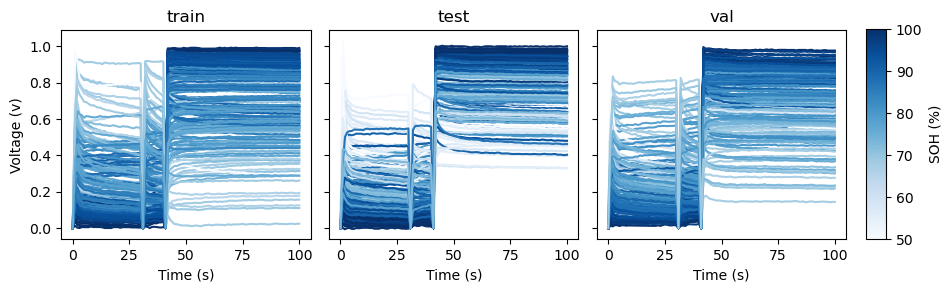

In [19]:
charge_samples.fit_transform(
    fit="train.features",
    apply="features",
    transform=FeatureTransform(MinMaxScaler())
)
fig, axes = plot_voltages(charge_samples)
plt.show()

Note that a `SegmentedScaler` class is provided in `modularml.preprocessing` that does the same things as `MyScaler`, except it allows for configurable boundaries and provides extra error checking.


Unfortunately, full serialization of custom scalers is not yet supported.
In order to reuse this FeatureSet (and underlying transforms), we'll switch to the built-in `SegmentedScaler` class.

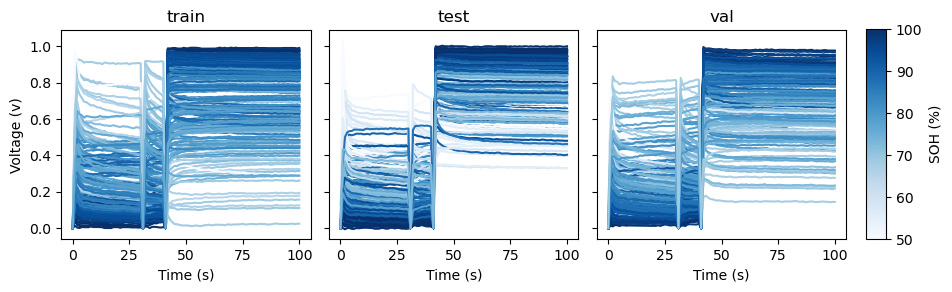

In [20]:
from modularml.preprocessing import SegmentedScaler

charge_samples.undo_all_transforms()

scaler = SegmentedScaler(
	boundaries=[0,31,41,101],
	scaler=PerSampleZeroStart()
)
charge_samples.fit_transform(
    fit="train.features",
    apply="features",
    transform=FeatureTransform(scaler)
)
charge_samples.fit_transform(
    fit="train.features",
    apply="features",
    transform=FeatureTransform(MinMaxScaler())
)

fig, axes = plot_voltages(charge_samples)
plt.show()


When using built-in transforms, `FeatureSet` instances are fully seriallizable, meaning that subsets, transforms, and underlying sample data can be saved and restored with the `save` and `load` methods.

Let's save our pre-processed `charge_samples` FeatureSet for use in later example notebooks. We'll put in the same folder as the downloaded data.

In [21]:
charge_samples.save(DATA_DIR / "charge_samples", overwrite_existing=True)

# Reloading the feature set can be achieved with:
# charge_samples = FeatureSet.load(DATA_DIR / "charge_samples")

In [22]:
fs_reload = FeatureSet.load(DATA_DIR / "charge_samples")

This concludes the **01_featureset_basics** notebook.

The next tutorial covers ModelGraph construction: [02_modelgraph_basics.ipynb](./02_modelgraph_basics.ipynb)